In [1]:
import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import time

## Data Loader

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Tạo thư mục để lưu ảnh
# images_dir = './saved_images'
# os.makedirs(images_dir, exist_ok=True)

batch_size = 32
trainset = torchvision.datasets.CIFAR10(root='./saved_images', train=True, download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./saved_images', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(len(trainloader))
print(len(testloader))

1563
313


## Visualization

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

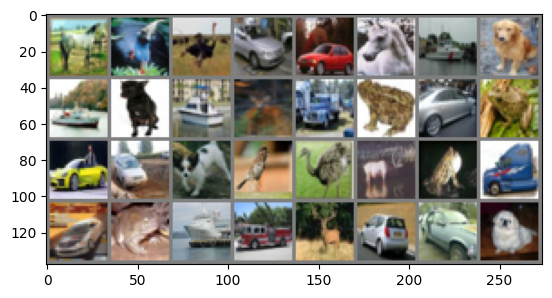

In [5]:
imshow(torchvision.utils.make_grid(images))

In [6]:
print(' '.join(f'{classes[j]}' for j in labels))

horse bird bird car car horse ship dog ship dog ship deer truck frog car frog car car dog bird bird deer frog truck car frog ship truck deer car car dog


## Define Residual Neural Network

In [7]:
import torch
from torch import nn
from torchsummary import summary

class ResidualBlockPytorch(nn.Module):
    def __init__(self, num_channels, output_channels, strides=1, is_used_conv11=False, **kwargs):
        super(ResidualBlockPytorch, self).__init__(**kwargs)
        self.is_used_conv11 = is_used_conv11
        self.conv1 = nn.Conv2d(num_channels, num_channels, padding=1,
                               kernel_size=3, stride=1)
        self.batch_norm = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels, padding=1,
                               kernel_size=3, stride=1)
        if self.is_used_conv11:
            self.conv3 = nn.Conv2d(num_channels, num_channels, padding=0,
                               kernel_size=1, stride=1)
        # Last convolutional layer to reduce output block shape.
        self.conv4 = nn.Conv2d(num_channels, output_channels, padding=0,
                               kernel_size=1, stride=strides)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        if self.is_used_conv11:
            Y = self.conv3(X)
        else:
            Y = X
        X = self.conv1(X)
        X = self.relu(X)
        X = self.batch_norm(X)
        X = self.relu(X)
        X = self.conv2(X)
        X = self.batch_norm(X)
        X = self.relu(X+Y)
        X = self.conv4(X)
        return X


class ResNet18PyTorch(nn.Module):
    def __init__(self, residual_blocks, output_shape):
        super(ResNet18PyTorch, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7,
                               stride=2, padding=3)
        self.batch_norm = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.residual_blocks = nn.Sequential(*residual_blocks)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.global_avg_pool = nn.Flatten()
        self.dense = nn.Linear(in_features=512, out_features=output_shape)

    def forward(self, X):
        X = self.conv1(X)
        X = self.batch_norm(X)
        X = self.relu(X)
        X = self.max_pool(X)
        X = self.residual_blocks(X)
        X = self.global_avg_pool(X)
        X = self.dense(X)
        return X

residual_blocks = [
    # Two start conv mapping
    ResidualBlockPytorch(num_channels=64, output_channels=64, strides =2, is_used_conv11=False),
    ResidualBlockPytorch(num_channels=64, output_channels=64, strides=2, is_used_conv11=False),
    # Next three [conv mapping + identity mapping]
    ResidualBlockPytorch(num_channels=64, output_channels = 128, strides = 2, is_used_conv11=True),
    ResidualBlockPytorch(num_channels=128, output_channels=128, strides=2, is_used_conv11=False),
    ResidualBlockPytorch(num_channels=128, output_channels=256, strides=2, is_used_conv11=True),
    ResidualBlockPytorch(num_channels=256, output_channels=256, strides=2, is_used_conv11=False),
    ResidualBlockPytorch(num_channels=256, output_channels=512, strides=2, is_used_conv11=False),
    ResidualBlockPytorch(num_channels= 512, output_channels=512, strides=2, is_used_conv11=False)
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.cuda.current_device()
ptmodel = ResNet18PyTorch(residual_blocks, output_shape=10)
ptmodel.to(device)
summary(ptmodel, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,472
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
              ReLU-6             [-1, 64, 7, 7]               0
       BatchNorm2d-7             [-1, 64, 7, 7]             128
              ReLU-8             [-1, 64, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          36,928
      BatchNorm2d-10             [-1, 64, 7, 7]             128
             ReLU-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 4, 4]           4,160
ResidualBlockPytorch-13             [-1, 64, 4, 4]               0
           Conv2d-14             [-1

### Build EarlyStopping

In [8]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.Inf
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                print("Early stopping")
                self.early_stop = True
#         return self.early_stop

### **Optimize**
* Batch_size = 32
* lr = 0.01

In [9]:
# Test GPU
torch.cuda.is_available()

True

In [10]:
!nvidia-smi

Thu Mar 21 17:32:26 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:17:00.0 Off |                  Off |
| 30%   48C    P2    61W / 230W |   1471MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:18:00.0 Off |                  Off |
| 30%   

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ptmodel.parameters(), lr=0.01, momentum=0.9)

def acc(output, label):
    return (torch.argmax(output, axis=1)==label).float().mean()

* Phải extract loss, acc, val_acc 
* So sánh L1, L2, Dropout, earling stopping, 

In [12]:
import time

train_losses = []
valid_losses = []

acc_train_list=[]
acc_val_list=[]

train_loss = 0

early_stopping = EarlyStopping(patience=5, min_delta = 0.01)

for epoch in range(35):  # loop over the dataset multiple times
    total_loss = 0.0
    tic = time.time()
    tic_step = time.time()
    train_acc = 0.0
    valid_acc = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = ptmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
                
            
        train_acc += acc(outputs, labels)
        # print statistics
        total_loss += loss.item()
        if i % 500 == 499:

            print("    iter %d: loss %.3f, train acc %.3f in %.1f sec" % (
            i+1, total_loss/i, (train_acc * 100)/i, time.time()-tic_step))
            tic_step = time.time()
    
    train_losses.append(loss.item())
    
    # calculate validation accuracy
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        valid_acc += acc(ptmodel(inputs), labels)
        loss_val = criterion(ptmodel(inputs), labels)
        # record validation loss
    
    valid_losses.append(loss_val.item())

        
    acc_train_list.append((train_acc*100)/len(trainloader))    
    acc_val_list.append((100*valid_acc)/len(testloader))
    print("Epoch %d: loss %.3f, train acc %.3f, test acc %.3f, in %.1f sec" % (
            epoch, total_loss/len(trainloader), (train_acc*100)/len(trainloader),
            (100*valid_acc)/len(testloader), time.time()-tic))
    if early_stopping(loss_val):
        break

print('Finished Training')

    iter 500: loss 2.147, train acc 18.330 in 8.8 sec
    iter 1000: loss 2.037, train acc 21.368 in 7.5 sec
    iter 1500: loss 1.962, train acc 24.043 in 7.8 sec
Epoch 0: loss 1.954, train acc 24.246, test acc 29.663, in 28.2 sec
    iter 500: loss 1.817, train acc 29.227 in 9.8 sec
    iter 1000: loss 1.767, train acc 31.309 in 9.8 sec
    iter 1500: loss 1.739, train acc 32.864 in 8.6 sec
Epoch 1: loss 1.735, train acc 33.005, test acc 37.111, in 32.3 sec
    iter 500: loss 1.634, train acc 38.333 in 9.9 sec
    iter 1000: loss 1.622, train acc 39.133 in 10.0 sec
    iter 1500: loss 1.597, train acc 40.102 in 10.4 sec
Epoch 2: loss 1.592, train acc 40.209, test acc 42.682, in 34.6 sec
    iter 500: loss 1.483, train acc 45.121 in 8.5 sec
    iter 1000: loss 1.469, train acc 45.611 in 8.4 sec
    iter 1500: loss 1.451, train acc 46.229 in 7.3 sec
Epoch 3: loss 1.448, train acc 46.323, test acc 48.383, in 28.6 sec
EarlyStopping counter: 1 out of 5
    iter 500: loss 1.346, train acc 

    iter 1000: loss 0.417, train acc 86.371 in 9.2 sec
    iter 1500: loss 0.426, train acc 86.026 in 8.8 sec
Epoch 31: loss 0.426, train acc 85.982, test acc 70.288, in 32.0 sec
EarlyStopping counter: 14 out of 5
Early stopping
    iter 500: loss 0.384, train acc 87.544 in 8.4 sec
    iter 1000: loss 0.405, train acc 86.677 in 9.3 sec
    iter 1500: loss 0.408, train acc 86.604 in 8.9 sec
Epoch 32: loss 0.409, train acc 86.466, test acc 69.798, in 30.5 sec
EarlyStopping counter: 15 out of 5
Early stopping
    iter 500: loss 0.378, train acc 87.857 in 9.3 sec
    iter 1000: loss 0.390, train acc 87.312 in 7.0 sec
    iter 1500: loss 0.402, train acc 86.847 in 8.2 sec
Epoch 33: loss 0.401, train acc 86.832, test acc 70.198, in 28.5 sec
EarlyStopping counter: 16 out of 5
Early stopping
    iter 500: loss 0.366, train acc 88.264 in 8.6 sec
    iter 1000: loss 0.376, train acc 87.788 in 7.6 sec
    iter 1500: loss 0.386, train acc 87.273 in 7.1 sec
Epoch 34: loss 0.385, train acc 87.252, t

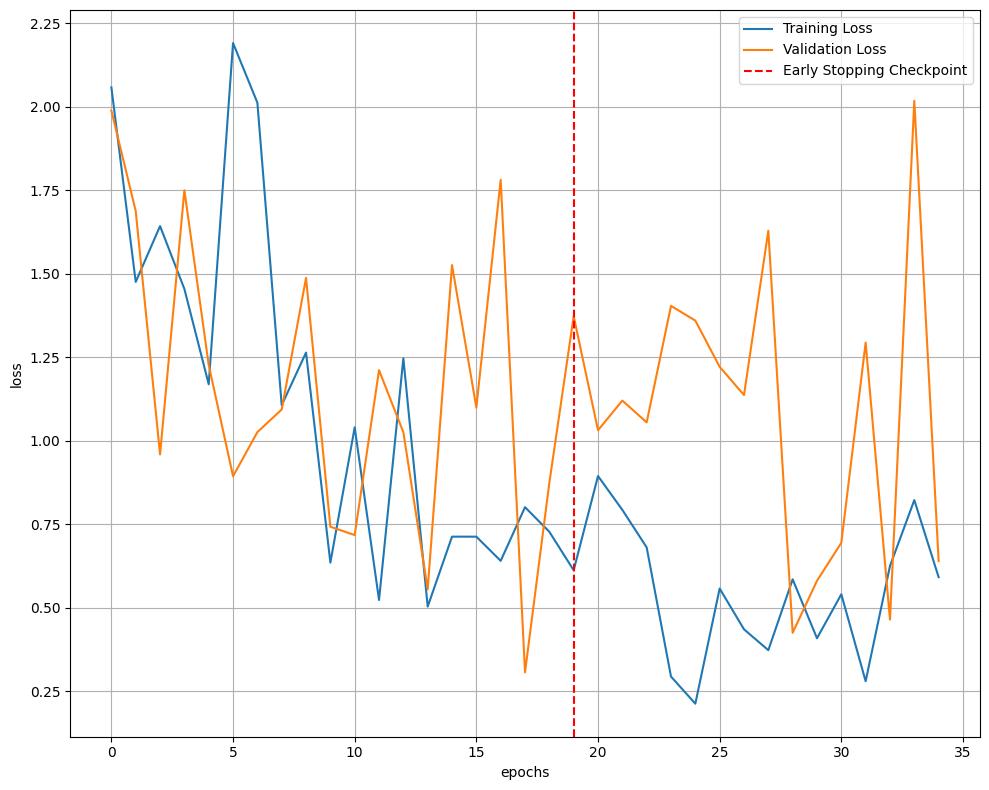

In [23]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(np.arange(35),train_losses, label='Training Loss')
plt.plot(np.arange(35),valid_losses,label='Validation Loss')

# find position of lowest validation loss
# minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(23-4, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# fig.savefig('loss_plot.png', bbox_inches='tight')

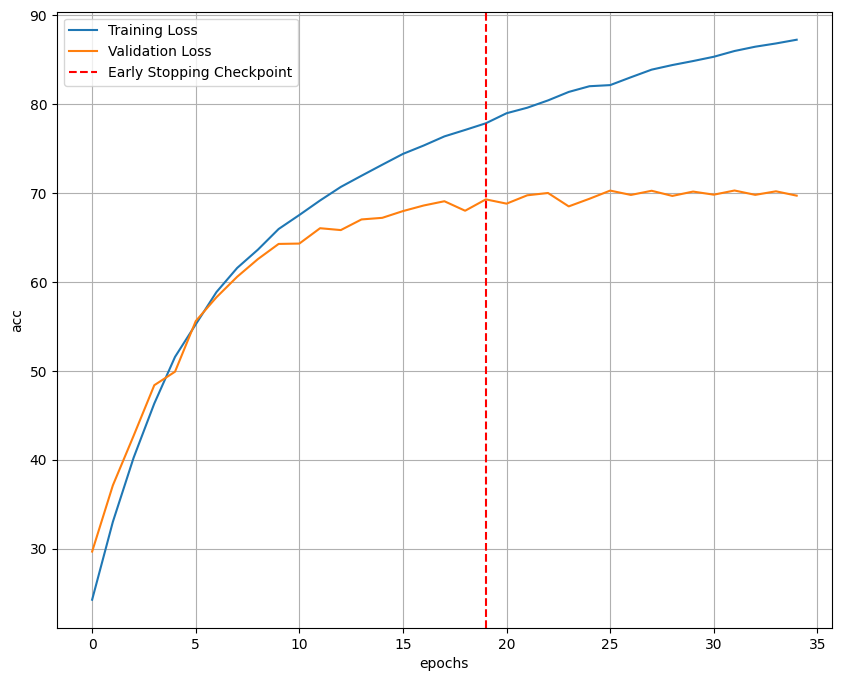

In [22]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(np.arange(35),convert_tensor(acc_train_list), label='Training Loss')
plt.plot(np.arange(35),convert_tensor(acc_val_list),label='Validation Loss')

# find position of lowest validation loss
# minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(23-4, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('acc')
# plt.ylim(0, 0.5) # consistent scale
# plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
# plt.tight_layout()
plt.show()
# fig.savefig('loss_plot.png', bbox_inches='tight')

In [17]:
def convert_tensor(x):
    # Chuyển tensor về numpy array
    return np.array([tensor.cpu().detach().numpy() for tensor in x])

# Note:

* Early Stopping in loss => optimize accuracy in trainset, testset no change (high bias, low variance, train: 96.95, val:0.71"
* Early Stopping in acc val 

## Turning Learning rate

In [6]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.001,
   'momentum': 0.9,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73]}]}

In [4]:
from torch_lr_finder import LRFinder
from torch import optim
from torch import nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ptmodel.parameters(), momentum=0.9)

/data2/chinh/anaconda3/envs/An/lib/python3.11/site-packages/torch_lr_finder/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [11]:
lr_finder = LRFinder(ptmodel, optimizers, criterion, device="cuda" if torch.cuda.is_available() else "cpu")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")

 45%|████▌     | 45/100 [00:01<00:01, 36.42it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.15E-02


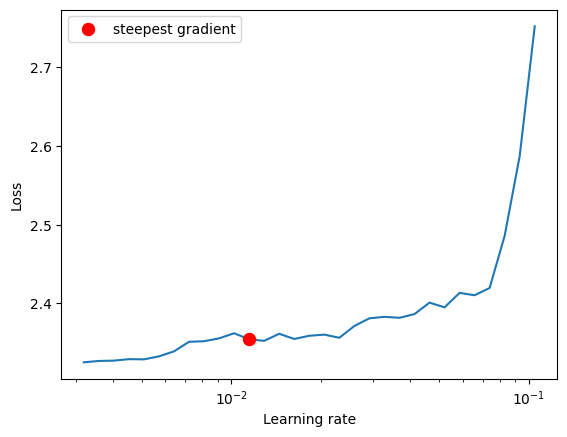

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 0.011497569953977358)

In [12]:
lr_finder.plot()

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ptmodel.parameters(),lr=1.15E-02, momentum=0.9)

## Regularization

L2 (Ridge Regresison)

In [ ]:
# List to maintain the different cross-validation scores
cross_val_scores_ridge = []
 
# List to maintain the different values of alpha
alpha = []
 
# Loop to compute the different values of cross-validation scores
for i in range(1, 9):
    ridgeModel = Ridge(alpha = i * 0.25)
    ridgeModel.fit(X_train, y_train)
    scores = cross_val_score(ridgeModel, X, y, cv = 10)
    avg_cross_val_score = mean(scores)*100
    cross_val_scores_ridge.append(avg_cross_val_score)
    alpha.append(i * 0.25)

# Loop to print the different values of cross-validation scores
for i in range(0, len(alpha)):
    print(str(alpha[i])+' : '+str(cross_val_scores_ridge[i]))

In [ ]:
# Building and fitting the Ridge Regression model
ridgeModelChosen = Ridge(alpha = 2)
ridgeModelChosen.fit(X_train, y_train)
 
# Evaluating the Ridge Regression model
print(ridgeModelChosen.score(X_test, y_test))

L1 (Lassor Regression)

In [ ]:
# List to maintain the cross-validation scores
cross_val_scores_lasso = []
 
# List to maintain the different values of Lambda
Lambda = []
 
# Loop to compute the cross-validation scores
for i in range(1, 9):
    lassoModel = Lasso(alpha = i * 0.25, tol = 0.0925)
    lassoModel.fit(X_train, y_train)
    scores = cross_val_score(lassoModel, X, y, cv = 10)
    avg_cross_val_score = mean(scores)*100
    cross_val_scores_lasso.append(avg_cross_val_score)
    Lambda.append(i * 0.25)

# Loop to print the different values of cross-validation scores
for i in range(0, len(alpha)):
    print(str(alpha[i])+' : '+str(cross_val_scores_lasso[i]))

In [ ]:

# Building and fitting the Lasso Regression Model
lassoModelChosen = Lasso(alpha = 2, tol = 0.0925)
lassoModelChosen.fit(X_train, y_train)
 
# Evaluating the Lasso Regression model
print(lassoModelChosen.score(X_test, y_test))